In [37]:
from __future__ import annotations

import jax
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed
from jaxopt import OptaxSolver
from optax import adam
from functools import partial
import jax.scipy as jsp
from plothelp import autoplot
import pyhf

pyhf.set_backend("jax")

# matplotlib settings
plt.rc("figure", figsize=(6, 3), dpi=150, facecolor="w")
plt.rc("legend", fontsize=6)

# Binning optimisation with `relaxed` and gradient descent

Normally, when we choose a binning, we pick something with uniform widths. It's easy, convenient, and can often aid in reasoning. However, if you wanted to squeeze every last drop of sensitivity out of an analysis, this binning (i.e. the location of the bin edges) can be further optimised for the best significance. That's what we'll be exploring below.

To start, we'll generate some toy signal and background data to play with.

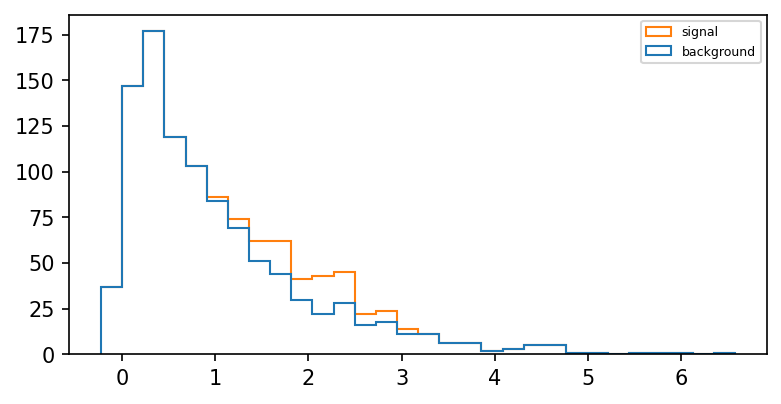

In [38]:
# generate background data from an exponential distribution with a little noise
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 1000, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

plt.hist(
    [bkg, sig], stacked=True, bins=30, histtype="step", label=["background", "signal"]
)
plt.legend();

Here we've just used an arbitrary binning for display purposes, but now we'll seek to find something more optimal. We can come up with a criteria for this using the infamous formula for median discovery significance in the case of known background:

$$
Z_A = 2 \sum_{i=0}^{\mathrm{num~bins-1}}(s_i + b_i)\log(1 + s_i / b_i) - s_i
$$

We can then seek to minimise 1/$Z_A$ (since there are far more minimisation than maximisation routines) using gradient descent. One optimisation step will then involve constructing the histogram with our current binning, calculating the significance of that histogram, then updating the bin edges with the gradient of the significance. For the last step, we'll use the `jaxopt` library for minimisation, and the `adam` optimiser from `optax`.

There is one important caveat though -- this workflow contains histograms, which are not a differentiable operation. To circumvent this issue, we'll be using `relaxed.hist`, which is a surrogate for the traditional histogram calculated via kernel density estimation. The main difference is that `relaxed.hist` has a parameter called the *bandwidth*, where lower bandwidth = less approximation [but more unstable gradients]. (see section 2.1 of https://arxiv.org/abs/2203.05570 for more info). Note that after optimisation, we'd use this binning for a true histogram, so we should calculate that significance too as our main performance measure.

Below, we set this all up, then perform the optimisation!

In [39]:
# differentiable significance pipeline
def asimov_pipe(bins, s, b, bandwidth=1e-2):
    # restrict bin edges so they don't overlap during optimisation
    bins_new = jnp.concatenate(
        (
            jnp.array([bins[0]]),
            jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
        ),
        axis=0,
    )
    # make differentiable histograms for each dataset
    s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
    b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
    # 1/significance because we want to minimise this function
    return 1 / relaxed.metrics.asimov_sig(s_hist, b_hist)


# significance with true histograms for comparison
def hard_asimov_pipe(bins, s, b):
    s_hist = jnp.histogram(s, bins=bins)[0] + 1e-4
    b_hist = jnp.histogram(b, bins=bins)[0] + 1e-4
    return relaxed.metrics.asimov_sig(s_hist, b_hist)

In [40]:
# optimisation!
def run(num_bins):
    bins = jnp.linspace(0, 8, num_bins + 1)
    loss = partial(asimov_pipe, s=sig, b=bkg, bandwidth=1e-1)
    solver = OptaxSolver(loss, adam(learning_rate=1e-3), maxiter=10000, tol=1e-6)
    opt = solver.run(bins).params
    return opt


# scan over a range of bin numbers to find the best significance
bin_number_range_to_scan = [2, 4, 6, 8, 10]
results = [run(i) for i in bin_number_range_to_scan]

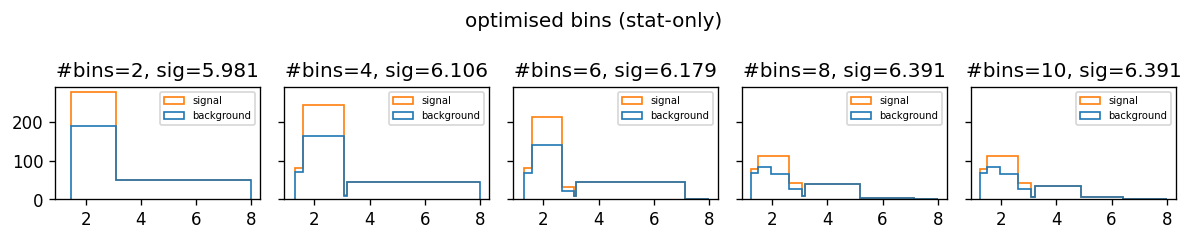

In [41]:
def plot_bins(ax, bins_opt, i) -> None:
    ax.hist(
        [bkg, sig],
        stacked=True,
        bins=bins_opt,
        histtype="step",
        label=["background", "signal"],
    )
    ax.legend()
    significance = hard_asimov_pipe(bins_opt, sig, bkg)
    ax.set_title(f"#bins={len(bins_opt)-1}, sig={significance:.3f}")


_ = autoplot(
    data=results,
    subplot_kwargs={"sharex": True, "sharey": True},
    plot_func=plot_bins,
    title="optimised bins (stat-only)",
)

## Systematic-aware binning (prototype)

The above code concerns the problem of optimising with known background. A more realistic scenario would be that we have some kind of uncertainty on this background, which would strongly affect the significance if it isn't negligible.

Not to worry -- we can still optimise while accounting for this uncertainty! The issue is that we're now forced to describe in detail our statistical modelling step, as this will let us calculate the significance in a way that includes the treatment of nuisance parameters that model the background uncertainty.

We'll look at the case of a simple three-point systematic, which contains a nominal estimation of the background histogram at the best estimate of some physical parameter, e.g. the jet energy scale (JES), but also two variations of the background that correspond to simulating physics at+-1 standard deviations away from that estimate. Here, we're just going to transpose the background data to the right and the left by a shift value.



In [42]:
shift = 0.4
bup = bkg + shift
bdown = bkg - shift

# specify the workspace for a simple model with a three-point background systematic
def correlated_background(signal, bkg, bkg_up, bkg_down):
    spec = {
        "channels": [
            {
                "name": "single_channel",
                "samples": [
                    {
                        "name": "signal",
                        "data": signal,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": bkg,
                        "modifiers": [
                            {
                                "name": "correlated_bkg_uncertainty",
                                "type": "histosys",
                                "data": {"hi_data": bkg_up, "lo_data": bkg_down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(
        spec, validate=False
    )  # false validation enables the use of jax arrays


# pipeline to calculate the full CLs for the model, given a number of bins
def pipe(num_bins):
    # make a dummy model with unit yields
    model = correlated_background(*[jnp.ones(num_bins)] * 4)

    def cls_pipe(bins, s, b, bup, bdown, bandwidth=1e-2):
        # restrict bin edges so they don't overlap
        bins_new = jnp.concatenate(
            (
                jnp.array([bins[0]]),
                jnp.where(bins[1:] > bins[:-1], bins[1:], bins[:-1] + 1e-4),
            ),
            axis=0,
        )
        s_hist = relaxed.hist(s, bins=bins_new, bandwidth=bandwidth) + 1e-4
        b_hist = relaxed.hist(b, bins=bins_new, bandwidth=bandwidth) + 1e-4
        bup_hist = relaxed.hist(bup, bins=bins_new, bandwidth=bandwidth) + 1e-4
        bdown_hist = relaxed.hist(bdown, bins=bins_new, bandwidth=bandwidth) + 1e-4

        # we hack our new values into the model since we already have the structure
        # NB: this only approximates the model (there's other metadata to edit somewhere)
        # but it's good enough for a loose optimisation, and it's super fast!
        model.main_model.nominal_rates = jnp.stack([b_hist, s_hist]).reshape(
            model.main_model.nominal_rates.shape
        )
        model.main_model.modifiers_appliers["histosys"]._histosys_histoset = [
            [[bdown_hist, b_hist, bup_hist], [s_hist] * 3]
        ]

        # differentiabe cls calculation
        nominal = (
            jnp.array(model.config.suggested_init()).at[model.config.poi_index].set(0.0)
        )
        data = model.expected_data(nominal)
        pval = relaxed.infer.hypotest(
            1, lr=1e-3, model=model, data=data, test_stat="q", expected_pars=nominal
        )
        return pval

    return cls_pipe


# use true histograms to calculate the CLs for a given binning
def pipe_uncert_hard(bins, s, b):
    s_hist = jnp.histogram(s, bins=bins)[0] + 1e-4
    b_hist = jnp.histogram(b, bins=bins)[0] + 1e-4
    bup_hist = jnp.histogram(bup, bins=bins)[0] + 1e-4
    bdown_hist = jnp.histogram(bdown, bins=bins)[0] + 1e-4
    uncert = jnp.abs(bup_hist - bdown_hist) + 1e-4
    model = correlated_background(s_hist, b_hist, bup_hist, bdown_hist)
    nominal = model.config.suggested_init()
    data = model.expected_data(nominal)
    pval = pyhf.infer.hypotest(0, pdf=model, data=data, test_stat="q0")
    return jsp.stats.norm.ppf(1 - pval), [s_hist, b_hist, uncert]

In [44]:
# optimisation!
def run_uncert(num_bins):
    bins = jnp.linspace(0, 8, num_bins + 1)
    cls_pipe = pipe(num_bins)
    loss = partial(cls_pipe, s=sig, b=bkg, bup=bup, bdown=bdown, bandwidth=1e-1)
    solver = OptaxSolver(loss, adam(learning_rate=1e-3), maxiter=10000, tol=1e-6)
    opt = solver.run(bins).params
    return opt  # , pipe_uncert_hard(opt, sig, bkg)


# slower than before, since we're doing a full CLs calculation
bin_number_range_to_scan = [2, 4, 6, 8, 10]
many = [run_uncert(i) for i in bin_number_range_to_scan]

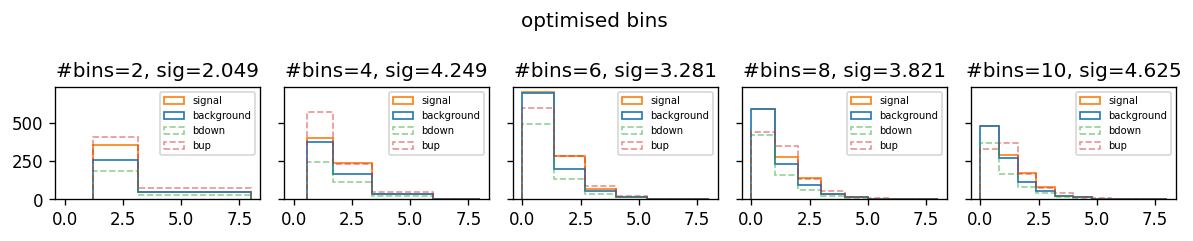

In [45]:
def plot_bins(ax, bins_opt, i, **kwargs) -> None:
    ax.hist(
        [bkg, sig],
        stacked=True,
        bins=bins_opt,
        histtype="step",
        label=["background", "signal"],
    )
    ax.hist(
        bdown.tolist(),
        bins=bins_opt,
        histtype="step",
        label="bdown",
        alpha=0.5,
        linestyle="--",
    )
    ax.hist(
        bup.tolist(),
        bins=bins_opt,
        histtype="step",
        label="bup",
        alpha=0.5,
        linestyle="--",
    )
    ax.legend()
    significance, _ = pipe_uncert_hard(bins_opt, sig, bkg)
    ax.set_title(f"#bins={len(bins_opt)-1}, sig={significance:.3f}")


_ = autoplot(
    data=many,
    subplot_kwargs={"sharex": True, "sharey": True},
    plot_func=plot_bins,
    title="optimised bins (including systematic uncertainty)",
)

In [ ]:
# comparison to stat-only:
_ = autoplot(
    data=results,
    subplot_kwargs={"sharex": True, "sharey": True},
    plot_func=plot_bins,
    title="optimised bins",
    outfile_name="optimised_bins.png",
)